<font size="10">Loan payment default risk prediction</font>

<font size="4">Project by: Utkarsh Singh (M13457333)</font>

# Project description

Home Credit is an international non-bank financial institution. Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

In this project, we will predict the **risk of default** in payment for a sample of current loans. We will use **5** datasets associated with a current loan in overall sample of loans. These are datasets include:

* Static header data about the loan and the applicant
* previous credit lines associated with the loan applicant as provided by the bureau datasets
* DPD data on these bureau credit lines
* Past instalments payments data on each loan in the sample
* Data on all credit applications made before the current loan

# Import important packages

In [ ]:
#Install Kaggle library
pip install kaggle

# - Log in to kaggle account
# - From the my account tab, download the API Token. Place it in "C:\Users\Hi\.kaggle" folder

In [2]:
import pandas as pd, numpy as np, scipy as sp, sklearn,requests,kaggle, matplotlib.pyplot as plt, seaborn as sb,plotly as ply, statsmodels as stat, tabulate,re,nltk

# Download data using Kaggle web API

In [4]:
#Import datafiles from kaggle API
!kaggle competitions download -c home-credit-default-risk -f application_train.csv
!kaggle competitions download -c home-credit-default-risk -f bureau.csv
!kaggle competitions download -c home-credit-default-risk -f bureau_balance.csv
!kaggle competitions download -c home-credit-default-risk -f installments_payments.csv
!kaggle competitions download -c home-credit-default-risk -f previous_application.csv


  0%|          | 0.00/36.1M [00:00<?, ?B/s]
  3%|2         | 1.00M/36.1M [00:00<00:06, 5.72MB/s]
 11%|#1        | 4.00M/36.1M [00:00<00:04, 7.34MB/s]
 19%|#9        | 7.00M/36.1M [00:00<00:03, 9.26MB/s]
 25%|##4       | 9.00M/36.1M [00:00<00:02, 11.0MB/s]
 30%|###       | 11.0M/36.1M [00:00<00:02, 12.3MB/s]
 36%|###6      | 13.0M/36.1M [00:00<00:01, 12.8MB/s]
 42%|####1     | 15.0M/36.1M [00:00<00:01, 14.5MB/s]
 50%|####9     | 18.0M/36.1M [00:01<00:01, 16.5MB/s]
 58%|#####8    | 21.0M/36.1M [00:01<00:00, 17.9MB/s]
 66%|######6   | 24.0M/36.1M [00:01<00:00, 19.1MB/s]
 72%|#######2  | 26.0M/36.1M [00:01<00:00, 18.1MB/s]
 80%|########  | 29.0M/36.1M [00:01<00:00, 19.7MB/s]
 89%|########8 | 32.0M/36.1M [00:01<00:00, 21.0MB/s]
 97%|#########6| 35.0M/36.1M [00:01<00:00, 21.9MB/s]
100%|##########| 36.1M/36.1M [00:01<00:00, 19.7MB/s]


The datasets are unzipped and stored at the local folder

# Define functions

In [157]:
# Define a function to left join multiple dataframes

def multiple_left_join(datalist,joining_key):
    input_size = len(datalist)
    keylist = list(range(1,input_size+1,1))
    datadict = dict.fromkeys(keylist)

    for k in datadict:  #  initialize data dictionary with dataframes
            datadict[k] = datalist[k-1]

    merged = datadict[1]

    for k in datadict:
        if(k+1<=input_size):
            merged = pd.merge(merged,datadict[k+1],how='left',on=joining_key)
        else:
            break
    return merged



# Define function to plot stacked bars for all categorical variables vs response - Shows distribution of response in each category

def plot_stacked_bars(df,target,dataid):
    categcolnames = list(df.select_dtypes(include = "object").columns)
    #categcolnames.remove(dataid)
    fig, axes = plt.subplots(4, 4, figsize=(40,40))

    for var,ax in zip(categcolnames,axes.flatten()):

        plotdf1 = df[[dataid,target,var]].groupby([var,target])[[dataid]].nunique().reset_index().pivot(index = var,columns = target,values =dataid).reset_index().replace(np.nan,0)
        totals = [i+j for i,j in zip(plotdf1[0], plotdf1[1])]
        nonevents = [i / j * 100 for i,j in zip(plotdf1[0], totals)]
        events = [i / j * 100 for i,j in zip(plotdf1[1], totals)]

        barWidth = 0.85
        names = df[var].unique()
        r = list(range(len(names)))
        # Create nonevents bar
        ax.bar(r, nonevents, color='blue', edgecolor='white', width=barWidth)
        # Create events Bars
        ax.bar(r, events, bottom=nonevents, color='orange', edgecolor='white', width=barWidth)
        # Custom x axis
        #ax.xticks(r, names, rotation=45)
        ax.set_title(var)
        ax.set_xticks(r)
        ax.set_xticklabels(names)


 # Define function to print number of records within each category of character columns       
def categorical_var_freq(df):
    x=0
    while x < len(list(df.select_dtypes(include = "object").columns)):
        varname = list(df.select_dtypes(include = "object").columns)[x]
        print(varname,"\n")
        print(pd.DataFrame(df[varname].value_counts()),"\n")
        x=x+1

# Define function to calculate Cramer's-V statstic for measuring association between categorical variables

import scipy.stats as ss

def cramers_v(X,Y):
    confusion_matrix = pd.crosstab(X,Y).values
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


# Define a asymmetric misclassification cost function for model validation - Weight of 10 assigned to False Negatives (Estimated from past experience)

def asymm_misclassif(predicted_prob,observed_y,p):
    FP = (predicted_prob>p) & (observed_y==0)
    FN = (predicted_prob<=p) & (observed_y==1)
    misclassification_rate = np.mean(FP+np.multiply(FN,10))
    return misclassification_rate


# Define a symmetric misclassification function for model validation 

def symm_misclassif(predicted_prob,observed_y,p):
    FP = (predicted_prob>p) & (observed_y==0)
    FN = (predicted_prob<=p) & (observed_y==1)
    misclassification_rate = np.mean(FP+FN)
    return misclassification_rate

# Data exploration

In [3]:
# Set working directory
import os
os.chdir("C:\\Users\\Hi\\Documents\\UC BANA Master\\1. Coursework\\7. Spring - 8090 Python\\Final Project\\Home Credit Data")

## Application header data

### Data description

This dataset contains static data on all applications. One row represents one loan in our data sample

In [96]:
apptrain = pd.read_csv('application_train.csv')
print(apptrain.shape)
print(apptrain['SK_ID_CURR'].nunique())

(307511, 122)
307511


### Column data types

In [8]:
# Check column datatypes
apptrain.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION             float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                   float64
FLAG_MOBIL                      int64
FLAG_EMP_PHONE                  int64
FLAG_WORK_PHONE                 int64
FLAG_CONT_MOBILE                int64
FLAG_PHONE  

### response variable distribution

In [10]:
# Check response variable distribution
apptrain["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

### Data summary

In [11]:
apptrain.drop(['SK_ID_CURR','TARGET'],axis=1).describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,-3254.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,-2010.000000,-1720.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


## Bureau data

### Data description

* This data consists of all client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
* For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [26]:
bureau = pd.read_csv('bureau.csv')
bureau = bureau.sort_values(['SK_ID_CURR', 'DAYS_CREDIT'])

In [7]:
bureau.head(10)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.00,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.80,42103.80,0.00,0.0,Consumer credit,-22,NaN
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.00,0.00,0.0,Consumer credit,-1710,NaN
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.0,0,103007.70,0.00,0.00,0.0,Consumer credit,-840,NaN
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.0,0,4500.00,0.00,0.00,0.0,Credit card,-690,NaN


### Column data types

In [9]:
bureau.dtypes

SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object

### Data Summary

In [17]:
print('Bureau credit lines available for:',bureau['SK_ID_CURR'].nunique(),' loans in our sample')
print('Total ',bureau['SK_ID_BUREAU'].nunique(''),' past bureau credit lines')

Bureau credit lines available for: 305811  loans in our sample
Total  1716428  past bureau credit lines


In [12]:
bureau.drop(['SK_ID_CURR','SK_ID_BUREAU'],axis=1).describe(include="all")

,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1716428,1716428,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1716428,1.716428e+06,4.896370e+05
unique,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN
top,Closed,currency 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer credit,NaN,NaN
freq,1079273,1715020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1251615,NaN,NaN
mean,NaN,NaN,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,NaN,-5.937483e+02,1.571276e+04
std,NaN,NaN,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,NaN,7.207473e+02,3.258269e+05
min,NaN,NaN,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,NaN,-4.194700e+04,0.000000e+00
25%,NaN,NaN,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-9.080000e+02,0.000000e+00
50%,NaN,NaN,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-3.950000e+02,0.000000e+00
75%,NaN,NaN,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,NaN,-3.300000e+01,1.350000e+04


## Bureau balance (DPD) data

### Data description

* Monthly balances of all previous credit lines in the Credit Bureau data
* This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

In [76]:
bureau_bal = pd.read_csv("bureau_balance.csv")

### Column data types

In [16]:
print(bureau_bal.dtypes)
bureau_bal.head(10)

SK_ID_BUREAU       int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


In [18]:
print('Balance data on ',bureau_bal['SK_ID_BUREAU'].nunique(''),' past bureau credit lines')

Balance data on  817395  past bureau credit lines


## Previous loans applications data (All previous home credit loans)

### Data description

* All previous applications for Home Credit loans of clients who have loans in our sample.
* There is one row for each previous application related to loans in our data sample.

In [94]:
prevapplications = pd.read_csv('previous_application.csv')
prevapplications.shape

(1670214, 37)

In [30]:
prevapplications.head(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,...,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
6,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
7,1656711,296299,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,7,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
8,2367563,342292,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,15,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
9,2579447,334349,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,15,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


### Column data types

In [31]:
prevapplications.dtypes

SK_ID_PREV                       int64
SK_ID_CURR                       int64
NAME_CONTRACT_TYPE              object
AMT_ANNUITY                    float64
AMT_APPLICATION                float64
AMT_CREDIT                     float64
AMT_DOWN_PAYMENT               float64
AMT_GOODS_PRICE                float64
WEEKDAY_APPR_PROCESS_START      object
HOUR_APPR_PROCESS_START          int64
FLAG_LAST_APPL_PER_CONTRACT     object
NFLAG_LAST_APPL_IN_DAY           int64
RATE_DOWN_PAYMENT              float64
RATE_INTEREST_PRIMARY          float64
RATE_INTEREST_PRIVILEGED       float64
NAME_CASH_LOAN_PURPOSE          object
NAME_CONTRACT_STATUS            object
DAYS_DECISION                    int64
NAME_PAYMENT_TYPE               object
CODE_REJECT_REASON              object
NAME_TYPE_SUITE                 object
NAME_CLIENT_TYPE                object
NAME_GOODS_CATEGORY             object
NAME_PORTFOLIO                  object
NAME_PRODUCT_TYPE               object
CHANNEL_TYPE             

### Data summary

In [32]:
print('Previous applications data available for:',prevapplications['SK_ID_CURR'].nunique(),' loans in our sample')
print('data available for ',prevapplications['SK_ID_PREV'].nunique(),' unique previous applications')

Previous applications data available for: 338857  loans in our sample
data available for  1670214  unique previous applications


## Past Home Credit loans instalments data

### Data description

* Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
* There is a) one row for every payment that was made plus b) one row each for missed payment.
* One row is equivalent to one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [86]:
paymenthistorydata = pd.read_csv('installments_payments.csv')
paymenthistorydata.head(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
5,1137312,164489,1.0,12,-1384.0,-1417.0,5970.375,5970.375
6,2234264,184693,4.0,11,-349.0,-352.0,29432.295,29432.295
7,1818599,111420,2.0,4,-968.0,-994.0,17862.165,17862.165
8,2723183,112102,0.0,14,-197.0,-197.0,70.740,70.740
9,1413990,109741,1.0,4,-570.0,-609.0,14308.470,14308.470


### Column data types

In [26]:
paymenthistorydata.dtypes

SK_ID_PREV                  int64
SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER       int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object

### Data Summary

In [27]:
print('Prev. home credit loans instalments data available for:',paymenthistorydata['SK_ID_CURR'].nunique(),' loans in our sample')
print('instalments data available for ',paymenthistorydata['SK_ID_PREV'].nunique(),' unique prev home credit loans')

Prev. home credit loans instalments data available for: 339587  loans in our sample
instalments data available for  997752  unique prev home credit loans


In [28]:
paymenthistorydata.drop(['SK_ID_CURR','SK_ID_PREV'],axis=1).describe(include="all")

,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


# Feature Engineering Part I

## Feature creation from different datasets

In this section, we will create predictor variables using data in each of the above datasets. This is the largest and the most detailed section of this project. At the end of this section we will have:

* A dataframe of aggregated features for each of the above datasets, unique at a SK_ID_CURR level (loan ID present in the training sample)
* Summary of each feature for sanity check

Features created by the end of this section will be later combined into a single master dataset which will be used for variable selection

### Bureau Data

In [34]:
loan_sample = apptrain[['SK_ID_CURR']]
loan_sample.shape

(307511, 1)

In [21]:
# Calculate number of active and closed bureau credit lines associated with the loans in sample

T1 = bureau.rename(columns={'CREDIT_ACTIVE':'bureaulinestatus'}).groupby(['SK_ID_CURR','bureaulinestatus'])[["SK_ID_BUREAU"]].nunique().reset_index().rename(columns={'SK_ID_BUREAU':'count'}).pivot(index='SK_ID_CURR',columns='bureaulinestatus',values='count').reset_index().replace(np.nan,0)
print(T1.shape)

#No of days before the current application when another credit was applied

T2 = bureau.sort_values(by = ["SK_ID_CURR","DAYS_CREDIT"]).groupby(["SK_ID_CURR"],as_index = False).nth(-1)[["SK_ID_CURR","DAYS_CREDIT"]].rename(columns={'DAYS_CREDIT':'DaysRecentBurCredApplied'})
print(T2.shape)

# Avg application interval between bureau credit lines

copy = bureau[['SK_ID_CURR','SK_ID_BUREAU','DAYS_CREDIT','CREDIT_ACTIVE','AMT_CREDIT_MAX_OVERDUE','CNT_CREDIT_PROLONG','AMT_CREDIT_SUM_DEBT','CREDIT_TYPE']].copy()
copy['application_interval'] = copy.groupby('SK_ID_CURR')['DAYS_CREDIT'].diff(-1)
missing_iter = iter(copy.groupby('SK_ID_CURR')['DAYS_CREDIT'].max())
copy['application_interval'] = copy['application_interval'].map(lambda x: -next(missing_iter) if np.isnan(x) else -x)
T3 = copy.groupby('SK_ID_CURR')[['application_interval']].mean().reset_index()
print(T3.shape)

# Maximum overdue days in any bureau credit line
T4 = bureau.groupby('SK_ID_CURR')[['CREDIT_DAY_OVERDUE']].max().reset_index().rename(columns={'CREDIT_DAY_OVERDUE':'max_CREDIT_DAY_OVERDUE'})
print(T4.shape)

# Total overdue days for all active bureau credit lines
T5 = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR')[['CREDIT_DAY_OVERDUE']].sum().reset_index().rename(columns={'CREDIT_DAY_OVERDUE':'Act_Total_Credit_Days_Overdue'})
T5 = pd.merge(loan_sample,T5,how='left',on='SK_ID_CURR').replace(np.nan,0)
print(T5.shape)

# Max overdue days for active bureau lines
T6 = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR')[['CREDIT_DAY_OVERDUE']].max().reset_index().rename(columns={'CREDIT_DAY_OVERDUE':'Act_Max_Credit_Days_Overdue'})
T6 = pd.merge(loan_sample,T6,how='left',on='SK_ID_CURR').replace(np.nan,0)
print(T6.shape)

# Sum of maximum overdue amount of bureau credit lines weighted by recency of line

copy['ADJ_DAYS'] = (copy.DAYS_CREDIT - copy.DAYS_CREDIT.min()) / (copy.DAYS_CREDIT.max() - copy.DAYS_CREDIT.min()) + 0.5
copy['ADJ_AMT_CREDIT_MAX_OVERDUE'] = copy.ADJ_DAYS * copy.AMT_CREDIT_MAX_OVERDUE
T7 = copy.groupby('SK_ID_CURR')[['ADJ_AMT_CREDIT_MAX_OVERDUE']].sum().reset_index()
print(T7.shape)

# Avg. max overdue amount weighted by recency
T8 = copy.groupby('SK_ID_CURR')[['ADJ_AMT_CREDIT_MAX_OVERDUE']].mean().reset_index()
print(T8.shape)

# Of all the bureau credit lines, what is the maximum overdue amount, for each loan sample
T9 = copy.groupby('SK_ID_CURR')[['AMT_CREDIT_MAX_OVERDUE']].max().reset_index()
print(T9.shape)

# Average number of times bureau credit lines were prolonged - for each loan sample - calculate weighted avg (by recency)
copy['ADJ_CNT_CREDIT_PROLONG'] = copy.ADJ_DAYS * copy.CNT_CREDIT_PROLONG
T10 = copy.groupby('SK_ID_CURR')[['ADJ_CNT_CREDIT_PROLONG']].mean().reset_index().replace(np.nan,0) # use adj days
print(T10.shape)

# Maximum number of times a bureau credit line was prolonged -  for each loan sample
T11 = copy.groupby('SK_ID_CURR')[['CNT_CREDIT_PROLONG']].max().reset_index().replace(np.nan,0)
print(T11.shape)

# Total debt of all active bureau credit lines - for each loan sample - weighted by recency
copy['ADJ_AMT_CREDIT_SUM_DEBT'] = copy.ADJ_DAYS * bureau.AMT_CREDIT_SUM_DEBT
T12 = copy[copy['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR')[['ADJ_AMT_CREDIT_SUM_DEBT']].sum().reset_index().rename(columns={'ADJ_AMT_CREDIT_SUM_DEBT':'ACT_ADJ_AMT_CREDIT_SUM_DEBT'})
T12 = pd.merge(loan_sample,T12,how='left',on='SK_ID_CURR').replace(np.nan,0)
print(T12.shape)

# Avg debt of all active bureau credit lines - for each loan sample - weighted by recency
T13 = copy[copy['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR')[['ADJ_AMT_CREDIT_SUM_DEBT']].mean().reset_index().rename(columns={'ADJ_AMT_CREDIT_SUM_DEBT':'ACT_AVG_ADJ_AMT_CREDIT_SUM_DEBT'})
T13 = pd.merge(loan_sample,T13,how='left',on='SK_ID_CURR').replace(np.nan,0)
print(T13.shape)

# Max debt of all active bureau credit lines - for each loan sample
T14 = copy[copy['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR')[['AMT_CREDIT_SUM_DEBT']].max().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'ACT_MAX_AMT_CREDIT_SUM_DEBT'})
T14 = pd.merge(loan_sample,T14,how='left',on='SK_ID_CURR').replace(np.nan,0)
print(T14.shape)

# Avg debt of all bureau credit lines - for each loan sample - weighted by recency
T15 = copy.groupby('SK_ID_CURR')[['ADJ_AMT_CREDIT_SUM_DEBT']].mean().reset_index().rename(columns={'ADJ_AMT_CREDIT_SUM_DEBT':'AVG_ADJ_AMT_CREDIT_SUM_DEBT'})
T15 = pd.merge(loan_sample,T15,how='left',on='SK_ID_CURR').replace(np.nan,0)
print(T15.shape)

# Max debt of all bureau credit lines - for each loan sample
T16 = copy.groupby('SK_ID_CURR')[['AMT_CREDIT_SUM_DEBT']].max().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'MAX_AMT_CREDIT_SUM_DEBT'})
T16 = pd.merge(loan_sample,T16,how='left',on='SK_ID_CURR').replace(np.nan,0)
print(T16.shape)


# Active accounts debt to credit ratio
interim_df = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR').agg({'AMT_CREDIT_SUM':['sum'],'AMT_CREDIT_SUM_DEBT':['sum'],'AMT_CREDIT_SUM_LIMIT':['sum'],'AMT_CREDIT_SUM_OVERDUE':['sum']}).reset_index()
interim_df.columns = interim_df.columns.get_level_values(0)
interim_df['ActDebtToCreditRatio'] = interim_df['AMT_CREDIT_SUM_DEBT']/interim_df['AMT_CREDIT_SUM']
interim_df['ActOverdueToDebtRatio'] = interim_df['AMT_CREDIT_SUM_OVERDUE']/interim_df['AMT_CREDIT_SUM_DEBT']
interim_df = interim_df.replace(np.nan,0)
T17 = interim_df[['SK_ID_CURR','AMT_CREDIT_SUM_LIMIT','AMT_CREDIT_SUM_OVERDUE','ActDebtToCreditRatio','ActOverdueToDebtRatio']].rename(columns={'AMT_CREDIT_SUM_LIMIT':'ACT_AMT_CREDIT_SUM_LIMIT','AMT_CREDIT_SUM_OVERDUE':'ACT_AMT_CREDIT_SUM_OVERDUE'})
T17 = pd.merge(loan_sample,T17,how='left',on='SK_ID_CURR').replace(np.nan,0)
print(T17.shape)

# How recently did the credit bureau info get updated - for each loan in the sample
T18 = bureau.groupby('SK_ID_CURR')[['DAYS_CREDIT_UPDATE']].max().reset_index()
print(T18.shape)


# Total bureau active credit lines per credit type
copy['credittypenew'] = copy["CREDIT_TYPE"].apply(lambda x: "Otherconsumerloan" if x in ('Consumer credit','Car loan','Microloan','Another type of loan','Unknown type of loan','Cash loan (non-earmarked)','Loan for purchase of shares (margin lending)') else ('commercialloan' if x in ('Loan for business development','Loan for working capital replenishment','Loan for the purchase of equipment','Real estate loan','Interbank credit','Mobile operator loan') else x))
actcredlinesdata = copy[copy["CREDIT_ACTIVE"] == "Active"].groupby(["SK_ID_CURR","credittypenew"])[["SK_ID_BUREAU"]].nunique().reset_index() 
actcredlinesdata['credittypenew'] = actcredlinesdata['credittypenew'].apply(lambda x: x + "_actcredlines")
T19 = actcredlinesdata.pivot(index = "SK_ID_CURR", columns = "credittypenew",values = "SK_ID_BUREAU").reset_index()
T19 = pd.merge(loan_sample,T19,how='left',on='SK_ID_CURR').replace(np.nan,0)
print(T19.shape)
T19.head()





(305811, 2)

In [72]:
# T5 = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR')[['CREDIT_DAY_OVERDUE']].sum().reset_index().rename(columns={'CREDIT_DAY_OVERDUE':'Act_Total_Credit_Days_Overdue'})
# T5 = pd.merge(loan_sample,T5,how='left',on='SK_ID_CURR').replace(np.nan,0)
# print(T5.shape)

# # Max overdue days for active bureau lines
# T6 = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR')[['CREDIT_DAY_OVERDUE']].max().reset_index().rename(columns={'CREDIT_DAY_OVERDUE':'Act_Max_Credit_Days_Overdue'})
# T6 = pd.merge(loan_sample,T6,how='left',on='SK_ID_CURR').replace(np.nan,0)
# print(T6.shape)

(307511, 2)
(307511, 2)


In [74]:
dflist = [loan_sample,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19]
joinkey = 'SK_ID_CURR'

bureau_features_merged = multiple_left_join(dflist,joinkey).replace(np.nan,0)

print(bureau_features_merged.shape)
bureau_features_merged.head(10)

(307511, 29)


,SK_ID_CURR,Active,Bad debt,Closed,Sold,DaysRecentBurCredApplied,application_interval,max_CREDIT_DAY_OVERDUE,Act_Total_Credit_Days_Overdue,Act_Max_Credit_Days_Overdue,...,MAX_AMT_CREDIT_SUM_DEBT,ACT_AMT_CREDIT_SUM_LIMIT,ACT_AMT_CREDIT_SUM_OVERDUE,ActDebtToCreditRatio,ActOverdueToDebtRatio,DAYS_CREDIT_UPDATE,Credit card_actcredlines,Mortgage_actcredlines,Otherconsumerloan_actcredlines,commercialloan_actcredlines
0,100002,2.0,0.0,6.0,0.0,-103.0,179.625000,0.0,0.0,0.0,...,245781.0,31988.565,0.0,0.509931,0.0,-7.0,1.0,0.0,1.0,0.0
1,100003,1.0,0.0,3.0,0.0,-606.0,646.500000,0.0,0.0,0.0,...,0.0,810000.000,0.0,0.000000,0.0,-43.0,1.0,0.0,0.0,0.0
2,100004,0.0,0.0,2.0,0.0,-408.0,663.000000,0.0,0.0,0.0,...,0.0,0.000,0.0,0.000000,0.0,-382.0,0.0,0.0,0.0,0.0
3,100006,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0.0,0.0,1.0,0.0,-1149.0,1149.000000,0.0,0.0,0.0,...,0.0,0.000,0.0,0.000000,0.0,-783.0,0.0,0.0,0.0,0.0
5,100008,1.0,0.0,2.0,0.0,-78.0,365.666667,0.0,0.0,0.0,...,240057.0,0.000,0.0,0.897054,0.0,-16.0,0.0,0.0,1.0,0.0
6,100009,4.0,0.0,14.0,0.0,-239.0,160.111111,0.0,0.0,0.0,...,557959.5,0.000,0.0,0.705274,0.0,-23.0,2.0,0.0,2.0,0.0
7,100010,1.0,0.0,1.0,0.0,-1138.0,1370.500000,0.0,0.0,0.0,...,348007.5,0.000,0.0,0.515567,0.0,-18.0,0.0,0.0,1.0,0.0
8,100011,0.0,0.0,4.0,0.0,-1309.0,627.000000,0.0,0.0,0.0,...,0.0,0.000,0.0,0.000000,0.0,-965.0,0.0,0.0,0.0,0.0
9,100012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
bureau_features_merged.drop(['SK_ID_CURR'],axis=1).describe(include="all")

,Active,Bad debt,Closed,Sold,DaysRecentBurCredApplied,application_interval,max_CREDIT_DAY_OVERDUE,Act_Total_Credit_Days_Overdue,Act_Max_Credit_Days_Overdue,ADJ_AMT_CREDIT_MAX_OVERDUE_x,...,MAX_AMT_CREDIT_SUM_DEBT,ACT_AMT_CREDIT_SUM_LIMIT,ACT_AMT_CREDIT_SUM_OVERDUE,ActDebtToCreditRatio,ActOverdueToDebtRatio,DAYS_CREDIT_UPDATE,Credit card_actcredlines,Mortgage_actcredlines,Otherconsumerloan_actcredlines,commercialloan_actcredlines
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,...,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,1.762275,0.000065,2.984391,0.018383,-419.255152,400.662128,4.089542,3.447496,3.326499,5.857682e+03,...,4.344722e+05,1.742709e+04,1.671665e+02,NaN,inf,-120.810241,0.801116,0.035404,0.924100,0.001655
std,1.804891,0.008064,3.359529,0.146403,526.292236,429.961922,82.531621,76.067471,73.348144,1.857542e+05,...,1.241232e+06,8.410842e+04,1.395571e+04,NaN,NaN,326.645995,1.112614,0.192841,1.128412,0.043135
min,0.000000,0.000000,0.000000,0.000000,-2922.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,-2.595965e+04,-5.798541e+05,0.000000e+00,-inf,-3.969900e-01,-41890.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,-537.000000,155.600000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-38.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,2.000000,0.000000,-239.000000,289.555556,0.000000,0.000000,0.000000,0.000000e+00,...,7.670700e+04,0.000000e+00,0.000000e+00,2.803600e-01,0.000000e+00,-15.000000,0.000000,0.000000,1.000000,0.000000
75%,3.000000,0.000000,4.000000,0.000000,-80.000000,500.800000,0.000000,0.000000,0.000000,0.000000e+00,...,3.941550e+05,0.000000e+00,0.000000e+00,7.254506e-01,0.000000e+00,-6.000000,1.000000,0.000000,1.000000,0.000000
max,32.000000,1.000000,108.000000,9.000000,0.000000,2922.000000,2792.000000,5250.000000,2770.000000,7.823776e+07,...,1.701000e+08,8.126600e+06,3.756681e+06,inf,inf,372.000000,17.000000,4.000000,17.000000,3.000000


### Bureau balance (DPD) data

In [83]:
# First create features at bureau ID level
bb_copy = bureau_bal.copy()

bb_copy['STATUS_mod'] = bb_copy.STATUS.map({'0':0, '1':1, '2':2, '3':3, '4':4, '5':5, 'X':np.nan, 'C':0}).map(lambda x: 0 if x=='C' else x).interpolate(method = 'linear')

## Create flag to identify if credit written off in the month
bb_copy['write_off'] = bb_copy.STATUS.map(lambda x: 1 if x=='5' else 0)

bb_month_count = bb_copy.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].count()

## Total number of months in DPD
bb_dpd_sum = bb_copy.groupby('SK_ID_BUREAU')['STATUS_mod'].sum()

## Total number of times written off 
bb_write_off = bb_copy.groupby('SK_ID_BUREAU')['write_off'].sum()

bb_dpd_sum_2_year = bb_copy.loc[bb_copy.MONTHS_BALANCE>=-24].groupby('SK_ID_BUREAU')['STATUS_mod'].sum()

## Total times written off in the past 2 years
bb_write_off_2_year = bb_copy.loc[bb_copy.MONTHS_BALANCE>=-24].groupby('SK_ID_BUREAU')['write_off'].sum()

## Merge individual features at Bureau ID level into a dataframe
bb_feature = pd.DataFrame({'bb_month_count':bb_month_count, 'bb_dpd_sum':bb_dpd_sum, 'bb_write_off':bb_write_off, 'bb_dpd_sum_2_year':bb_dpd_sum_2_year, 
                          'bb_write_off_2_year':bb_write_off_2_year}).reset_index().fillna(0)


# Merge with Current loan ID (sample loans)
bureau_bb = pd.merge(bureau[['SK_ID_CURR','SK_ID_BUREAU']],bb_feature, on='SK_ID_BUREAU', how='left')


# Now, start rolling up at loan ID level

## Avg. number of months for which data is 
bb1 = bureau_bb.groupby('SK_ID_CURR')[['bb_month_count']].mean().reset_index().rename(columns={'bb_month_count':'bb_AvgMonthCount'})

## Total number of overdue months for all bureau lines
bb2 = bureau_bb.groupby('SK_ID_CURR')[['bb_dpd_sum']].sum().reset_index().rename(columns={'bb_dpd_sum':'bb_TotalOverdueMonths'})


## Total number of times written off

bb3 = bureau_bb.groupby('SK_ID_CURR')[['bb_write_off']].sum().reset_index().rename(columns={'bb_write_off':'bb_TotalWrittenOff'})

## Maximum times overdue
bb4 = bureau_bb.groupby('SK_ID_CURR')[['bb_dpd_sum']].max().reset_index().rename(columns={'bb_write_off':'bb_MaxOverdueMonth'})

bureau_features_merged_all = multiple_left_join([bureau_features_merged,bb1,bb2,bb3,bb4],'SK_ID_CURR').replace(np.nan,0)

print(bureau_features_merged_all.shape)

bureau_features_merged_all.head(10)


(307511, 33)


,SK_ID_CURR,Active,Bad debt,Closed,Sold,DaysRecentBurCredApplied,application_interval,max_CREDIT_DAY_OVERDUE,Act_Total_Credit_Days_Overdue,Act_Max_Credit_Days_Overdue,...,ActOverdueToDebtRatio,DAYS_CREDIT_UPDATE,Credit card_actcredlines,Mortgage_actcredlines,Otherconsumerloan_actcredlines,commercialloan_actcredlines,bb_AvgMonthCount,bb_TotalOverdueMonths,bb_TotalWrittenOff,bb_dpd_sum
0,100002,2.0,0.0,6.0,0.0,-103.0,179.625000,0.0,0.0,0.0,...,0.0,-7.0,1.0,0.0,1.0,0.0,13.75,31.0,0.0,7.0
1,100003,1.0,0.0,3.0,0.0,-606.0,646.500000,0.0,0.0,0.0,...,0.0,-43.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,100004,0.0,0.0,2.0,0.0,-408.0,663.000000,0.0,0.0,0.0,...,0.0,-382.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
3,100006,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,100007,0.0,0.0,1.0,0.0,-1149.0,1149.000000,0.0,0.0,0.0,...,0.0,-783.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
5,100008,1.0,0.0,2.0,0.0,-78.0,365.666667,0.0,0.0,0.0,...,0.0,-16.0,0.0,0.0,1.0,0.0,0.00,0.0,0.0,0.0
6,100009,4.0,0.0,14.0,0.0,-239.0,160.111111,0.0,0.0,0.0,...,0.0,-23.0,2.0,0.0,2.0,0.0,0.00,0.0,0.0,0.0
7,100010,1.0,0.0,1.0,0.0,-1138.0,1370.500000,0.0,0.0,0.0,...,0.0,-18.0,0.0,0.0,1.0,0.0,36.00,0.0,0.0,0.0
8,100011,0.0,0.0,4.0,0.0,-1309.0,627.000000,0.0,0.0,0.0,...,0.0,-965.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
9,100012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [84]:
bureau_features_merged_all.drop(['SK_ID_CURR'],axis=1).describe(include="all")

,Active,Bad debt,Closed,Sold,DaysRecentBurCredApplied,application_interval,max_CREDIT_DAY_OVERDUE,Act_Total_Credit_Days_Overdue,Act_Max_Credit_Days_Overdue,ADJ_AMT_CREDIT_MAX_OVERDUE_x,...,ActOverdueToDebtRatio,DAYS_CREDIT_UPDATE,Credit card_actcredlines,Mortgage_actcredlines,Otherconsumerloan_actcredlines,commercialloan_actcredlines,bb_AvgMonthCount,bb_TotalOverdueMonths,bb_TotalWrittenOff,bb_dpd_sum
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,...,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,1.762275,0.000065,2.984391,0.018383,-419.255152,400.662128,4.089542,3.447496,3.326499,5.857682e+03,...,inf,-120.810241,0.801116,0.035404,0.924100,0.001655,8.241179,1.735592,0.131794,1.051348
std,1.804891,0.008064,3.359529,0.146403,526.292236,429.961922,82.531621,76.067471,73.348144,1.857542e+05,...,NaN,326.645995,1.112614,0.192841,1.128412,0.043135,15.603149,19.491047,2.817280,10.708836
min,0.000000,0.000000,0.000000,0.000000,-2922.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,-3.969900e-01,-41890.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,-537.000000,155.600000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,-38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,2.000000,0.000000,-239.000000,289.555556,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,-15.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,4.000000,0.000000,-80.000000,500.800000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,-6.000000,1.000000,0.000000,1.000000,0.000000,11.333333,0.000000,0.000000,0.000000
max,32.000000,1.000000,108.000000,9.000000,0.000000,2922.000000,2792.000000,5250.000000,2770.000000,7.823776e+07,...,inf,372.000000,17.000000,4.000000,17.000000,3.000000,97.000000,2100.000000,346.000000,446.877828


### Past Home Credit loans Instalments data

In [88]:

df = paymenthistorydata.copy()
df['concat_previd_instalnumber'] = df['SK_ID_PREV'].astype(str) + df['NUM_INSTALMENT_NUMBER'].astype(str)


# proportion of delayed payments in the past 1,3,6,9,12 months
datadict = {'d1':pd.DataFrame(),'d2':pd.DataFrame(),'d3':pd.DataFrame(),'d4':pd.DataFrame(),'d5':pd.DataFrame()}
keylist = ['d1','d2','d3','d4','d5']
cnt = 0
for i in [1,3,6,9,12]:
    cnt_late = df[(df['DAYS_INSTALMENT'] > -30*i) & (df['DAYS_ENTRY_PAYMENT'] >df['DAYS_INSTALMENT'])].groupby('SK_ID_CURR')[['concat_previd_instalnumber']].nunique().reset_index().rename(columns = {'concat_previd_instalnumber':'lateinstalmentpayments'})
    cnt_payments = df[(df['DAYS_INSTALMENT'] > -30*i)].groupby('SK_ID_CURR')[['concat_previd_instalnumber']].nunique().reset_index().rename(columns = {'concat_previd_instalnumber':'totalinstalments'})
    joined = pd.merge(cnt_payments,cnt_late,how = 'left',on = 'SK_ID_CURR')
    joined['propdelayedinstalpayments_'+str(i)+'months'] = joined['lateinstalmentpayments']/joined['totalinstalments']
    datadict[keylist[cnt]] = joined.drop(['lateinstalmentpayments','totalinstalments'],axis=1)
    cnt = cnt+1

instalpaymentsdelaydata = datadict['d1']
for data in [datadict['d2'],datadict['d3'],datadict['d4'],datadict['d5']]:
    instalpaymentsdelaydata = pd.merge(instalpaymentsdelaydata,data,how='outer',on = 'SK_ID_CURR')


#c - Use instalpaymentsdelaydata to join with main

# The earliest instalment made - Tenure of instalment
P1 = paymenthistorydata.sort_values(by=['SK_ID_CURR','DAYS_INSTALMENT'],ascending=True).groupby('SK_ID_CURR').nth(0).reset_index()[['SK_ID_CURR','DAYS_INSTALMENT']]
P1 = P1.rename(columns = {'DAYS_INSTALMENT':'instalmentTenure'})

#avg no. of days payments were made in advance

df = paymenthistorydata.copy()
datadict = {'d1':pd.DataFrame(),'d2':pd.DataFrame(),'d3':pd.DataFrame(),'d4':pd.DataFrame(),'d5':pd.DataFrame()}
keylist = ['d1','d2','d3','d4','d5']
cnt = 0
for i in [1,3,6,9,12]:
    d = df[df['DAYS_INSTALMENT'] > -30*i].sort_values(by=['SK_ID_PREV','NUM_INSTALMENT_NUMBER'], ascending=False).groupby(['SK_ID_PREV','NUM_INSTALMENT_NUMBER']).nth(0).reset_index()
    d['dayspaidinadvance'] = d['DAYS_INSTALMENT'] - d['DAYS_ENTRY_PAYMENT']
    datadict[keylist[cnt]] = d.groupby('SK_ID_CURR')[['dayspaidinadvance']].mean().reset_index().rename(columns={'dayspaidinadvance':'avgdaysinstalpaidinadvance_'+str(i)+'months'})
    cnt = cnt+1

P2 = datadict['d1']
for data in [datadict['d2'],datadict['d3'],datadict['d4'],datadict['d5']]:
    P2 = pd.merge(P2,data,how='outer',on = 'SK_ID_CURR')
    
pastinstalpaymentvars = pd.merge(instalpaymentsdelaydata, pd.merge(P1,P2,how='outer',on='SK_ID_CURR'), how='outer',on='SK_ID_CURR')



In [91]:
pastinstalpaymentvars.replace(np.nan,0,inplace=True)
print(pastinstalpaymentvars.shape)
pastinstalpaymentvars.head(10)

(339587, 12)


,SK_ID_CURR,propdelayedinstalpayments_1months,propdelayedinstalpayments_3months,propdelayedinstalpayments_6months,propdelayedinstalpayments_9months,propdelayedinstalpayments_12months,instalmentTenure,avgdaysinstalpaidinadvance_1months,avgdaysinstalpaidinadvance_3months,avgdaysinstalpaidinadvance_6months,avgdaysinstalpaidinadvance_9months,avgdaysinstalpaidinadvance_12months
0,100002,0.0,0.0,0.000000,0.000000,0.000000,-565.0,24.0,16.666667,17.000000,17.222222,17.583333
1,100006,0.0,0.0,0.000000,0.000000,0.000000,-545.0,1.0,1.000000,7.000000,6.400000,6.181818
2,100007,0.0,0.0,0.000000,0.000000,0.000000,-2326.0,0.0,0.333333,1.166667,1.888889,3.615385
3,100013,0.0,0.0,0.222222,0.133333,0.105263,-2705.0,0.0,0.000000,-0.666667,1.600000,1.315789
4,100017,0.0,0.0,0.000000,0.000000,0.000000,-2398.0,10.0,9.000000,10.000000,11.444444,11.416667
5,100018,0.0,0.0,0.000000,0.000000,0.000000,-1613.0,11.0,11.333333,14.800000,14.800000,14.800000
6,100021,0.0,0.0,0.000000,0.000000,0.000000,-2772.0,46.0,36.000000,25.166667,21.625000,21.625000
7,100022,0.0,0.0,0.000000,0.000000,0.000000,-209.0,22.0,23.000000,23.666667,23.428571,23.428571
8,100028,0.0,0.0,0.000000,0.000000,0.062500,-1773.0,2.0,1.000000,0.400000,0.700000,0.625000
9,100042,0.0,0.0,0.000000,0.000000,0.000000,-2719.0,0.0,0.000000,0.000000,0.000000,0.000000


In [93]:
# More features on past intalments data
paymenthistorydata = paymenthistorydata.sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])
payment_copy = paymenthistorydata.copy()
payment_copy['IS_CREDIT'] = payment_copy.NUM_INSTALMENT_VERSION.map(lambda x: 1 if x==0 else 0)
payment_copy['late_payment'] = (payment_copy.DAYS_INSTALMENT < payment_copy.DAYS_ENTRY_PAYMENT).map(lambda x: 1 if x==True else 0).fillna(0)
payment_copy['less_payment'] = (payment_copy.AMT_INSTALMENT > payment_copy.AMT_PAYMENT).map(lambda x: 1 if x==True else 0).fillna(0)

# Features regarding late and less payment in last 1 year

# total late and less payments in recent 1 year
payment_1y = payment_copy.loc[payment_copy.DAYS_ENTRY_PAYMENT>-365]
# payment 1 year
ip_payment_count_1y = payment_1y.groupby('SK_ID_CURR')['SK_ID_PREV'].count()
ip_creditcard_count_1y = payment_1y.groupby(['SK_ID_CURR','SK_ID_PREV'])['IS_CREDIT'].sum().map(lambda x: 1 if x>0 else 0).reset_index().groupby('SK_ID_CURR')['IS_CREDIT'].sum()
ip_total_late_times_1y = payment_1y.groupby('SK_ID_CURR')['late_payment'].sum()
ip_total_less_times_1y = payment_1y.groupby('SK_ID_CURR')['less_payment'].sum()

# total payment in recent 1 yr
ip_total_actual_payment_1y = payment_1y.groupby('SK_ID_CURR')['AMT_PAYMENT'].sum()
ip_total_required_payment_1y = payment_1y.groupby('SK_ID_CURR')['AMT_INSTALMENT'].sum()

# Features regarding late and less payment in last 6 months


# total late and less payments 
payment_6m = payment_copy.loc[payment_copy.DAYS_ENTRY_PAYMENT>-180]
# payment 1 year
ip_payment_count_6m = payment_6m.groupby('SK_ID_CURR')['SK_ID_PREV'].count()
ip_creditcard_count_6m = payment_6m.groupby(['SK_ID_CURR','SK_ID_PREV'])['IS_CREDIT'].sum().map(lambda x: 1 if x>0 else 0).reset_index().groupby('SK_ID_CURR')['IS_CREDIT'].sum()
ip_total_late_times_6m = payment_6m.groupby('SK_ID_CURR')['late_payment'].sum()
ip_total_less_times_6m = payment_6m.groupby('SK_ID_CURR')['less_payment'].sum()

# total payment 
ip_total_actual_payment_6m = payment_6m.groupby('SK_ID_CURR')['AMT_PAYMENT'].sum()
ip_total_required_payment_6m = payment_6m.groupby('SK_ID_CURR')['AMT_INSTALMENT'].sum()



# Features regarding late and less payment in last 3 months


# total late and less payments 
payment_3m = payment_copy.loc[payment_copy.DAYS_ENTRY_PAYMENT>-90]
# payment 1 year
ip_payment_count_3m = payment_3m.groupby('SK_ID_CURR')['SK_ID_PREV'].count()
ip_creditcard_count_3m = payment_3m.groupby(['SK_ID_CURR','SK_ID_PREV'])['IS_CREDIT'].sum().map(lambda x: 1 if x>0 else 0).reset_index().groupby('SK_ID_CURR')['IS_CREDIT'].sum()
ip_total_late_times_3m = payment_3m.groupby('SK_ID_CURR')['late_payment'].sum()
ip_total_less_times_3m = payment_3m.groupby('SK_ID_CURR')['less_payment'].sum()

# total payment 
ip_total_actual_payment_3m = payment_3m.groupby('SK_ID_CURR')['AMT_PAYMENT'].sum()
ip_total_required_payment_3m = payment_3m.groupby('SK_ID_CURR')['AMT_INSTALMENT'].sum()


# Features regarding late and less payment in last 1 month

# total late and less payments 
payment_1m = payment_copy.loc[payment_copy.DAYS_ENTRY_PAYMENT>-30]
# payment 1 year
ip_payment_count_1m = payment_1m.groupby('SK_ID_CURR')['SK_ID_PREV'].count()
ip_creditcard_count_1m = payment_1m.groupby(['SK_ID_CURR','SK_ID_PREV'])['IS_CREDIT'].sum().map(lambda x: 1 if x>0 else 0).reset_index().groupby('SK_ID_CURR')['IS_CREDIT'].sum()
ip_total_late_times_1m = payment_1m.groupby('SK_ID_CURR')['late_payment'].sum()
ip_total_less_times_1m = payment_1m.groupby('SK_ID_CURR')['less_payment'].sum()

# total payment 
ip_total_actual_payment_1m = payment_1m.groupby('SK_ID_CURR')['AMT_PAYMENT'].sum()
ip_total_required_payment_1m = payment_1m.groupby('SK_ID_CURR')['AMT_INSTALMENT'].sum()



pastinstalpaymentvars_more = pd.DataFrame({'ip_payment_count_1y':ip_payment_count_1y,'ip_creditcard_count_1y':ip_creditcard_count_1y,'ip_total_late_times_1y':ip_total_late_times_1y,'ip_total_less_times_1y':ip_total_less_times_1y,'ip_total_actual_payment_1y':ip_total_actual_payment_1y,'ip_total_required_payment_1y':ip_total_required_payment_1y,'ip_payment_count_6m':ip_payment_count_6m,'ip_creditcard_count_6m':ip_creditcard_count_6m,'ip_total_late_times_6m':ip_total_late_times_6m,'ip_total_less_times_6m':ip_total_less_times_6m,'ip_total_actual_payment_6m':ip_total_actual_payment_6m,'ip_total_required_payment_6m':ip_total_required_payment_6m,'ip_payment_count_3m':ip_payment_count_3m,'ip_creditcard_count_3m':ip_creditcard_count_3m,'ip_total_late_times_3m':ip_total_late_times_3m,'ip_total_less_times_3m':ip_total_less_times_3m,'ip_total_actual_payment_3m':ip_total_actual_payment_3m,'ip_total_required_payment_3m':ip_total_required_payment_3m,'ip_payment_count_1m':ip_payment_count_1m,'ip_creditcard_count_1m':ip_creditcard_count_1m,'ip_total_late_times_1m':ip_total_late_times_1m,'ip_total_less_times_1m':ip_total_less_times_1m,'ip_total_actual_payment_1m':ip_total_actual_payment_1m,'ip_total_required_payment_1m':ip_total_required_payment_1m}).reset_index().fillna(0)


### Previous loans applications data

In [95]:
# 1. Amount applied for the last application; 2. Avg. amt applied for all appl in the past;3.Avg.credit to requested amt ratio for applications in the past
#4. number of application under each type; 5. number of consumer loans with 0 down payment 
#6. Total number of past applications refused; 7. preferred channel for the prev applications 8. cnt of x-sell loans in the past



df = prevapplications[['SK_ID_CURR']].drop_duplicates()
X1 =  prevapplications.sort_values(by=['SK_ID_CURR','DAYS_DECISION'],ascending=False).groupby('SK_ID_CURR').nth(0).reset_index()[['SK_ID_CURR','AMT_APPLICATION']].rename(columns = {'AMT_APPLICATION':'lastapplamountrequested'})

X2 = prevapplications.groupby('SK_ID_CURR')[['AMT_APPLICATION']].mean().reset_index().rename(columns={'AMT_APPLICATION':'avgpastapplamountreq'})

X3 = pd.merge(prevapplications.groupby('SK_ID_CURR')[['AMT_CREDIT']].sum().reset_index(),prevapplications.groupby('SK_ID_CURR')[['AMT_APPLICATION']].sum().reset_index(),how='outer',on='SK_ID_CURR')
X3['pastapplamtcredittoreqratio'] = X3['AMT_CREDIT']/X3['AMT_APPLICATION']
X3 = X3.drop(['AMT_CREDIT','AMT_APPLICATION'],axis=1)

X4 = prevapplications.groupby(['SK_ID_CURR','NAME_CONTRACT_TYPE'])[['SK_ID_PREV']].nunique().reset_index().rename(columns={'SK_ID_PREV':'countappl'})
X4['NAME_CONTRACT_TYPE'] = X4['NAME_CONTRACT_TYPE'].apply(lambda x: 'pastapplcnt_' + x.replace(" ",""))
X4 = X4.pivot(index='SK_ID_CURR',columns='NAME_CONTRACT_TYPE',values='countappl').reset_index()
X4 = X4.replace(np.nan,0)


X5 = prevapplications[(prevapplications['NAME_CONTRACT_TYPE'] == 'Consumer loans') & (prevapplications['AMT_DOWN_PAYMENT'] == 0)].groupby('SK_ID_CURR')[['SK_ID_PREV']].nunique().reset_index().rename(columns={'SK_ID_PREV':'pastconsumerloans0downpaym'})
X5 = pd.merge(X4[['SK_ID_CURR','pastapplcnt_Consumerloans']],X5,how='left',on = 'SK_ID_CURR')
X5['propconsumerloanswith0downpaym'] = X5['pastconsumerloans0downpaym']/X5['pastapplcnt_Consumerloans']
X5 = X5.drop(['pastapplcnt_Consumerloans','pastconsumerloans0downpaym'],axis=1).replace(np.nan,0)


X6 = prevapplications[prevapplications['NAME_CONTRACT_STATUS'] == 'Refused'].groupby('SK_ID_CURR')[['SK_ID_PREV']].nunique().reset_index().rename(columns = {'SK_ID_PREV':'cntpastapplRefused'})


X7 = prevapplications.groupby(['SK_ID_CURR','CHANNEL_TYPE'])[['SK_ID_PREV']].nunique().reset_index()
X7['maxcnt'] = X7.groupby('SK_ID_CURR')['SK_ID_PREV'].transform(max)
X7['prefchannelflag'] = X7.apply(lambda x: 1 if x['SK_ID_PREV'] == x['maxcnt'] else 0,axis=1)
X7['cntprefchannels'] = X7.groupby('SK_ID_CURR')['prefchannelflag'].transform(sum)
X7.loc[X7['cntprefchannels'] > 1,'prefchannel'] = 'Multiple'
X7.loc[X7['cntprefchannels'] == 1,'prefchannel'] = X7['CHANNEL_TYPE']
X7 = X7[X7['SK_ID_PREV'] == X7['maxcnt']][['SK_ID_CURR','prefchannel']].drop_duplicates()


X8 = prevapplications[prevapplications['NAME_PRODUCT_TYPE'] == 'x-sell'].groupby('SK_ID_CURR')[['SK_ID_PREV']].nunique().reset_index().rename(columns={'SK_ID_PREV':'cntXsellcreditaccounts'})
X8 = pd.merge(df,X8,how='outer',on='SK_ID_CURR').replace(np.nan,0)


dflist = [loan_sample,X1,X2,X3,X4,X5,X6,X7,X8]
joinkey = 'SK_ID_CURR'

prevapplications_features = multiple_left_join(dflist,joinkey).replace(np.nan,0)

    


## Merge features from all datasets

In [100]:
dflist = [apptrain,bureau_features_merged_all,pastinstalpaymentvars,pastinstalpaymentvars_more, prevapplications_features]
joinkey = 'SK_ID_CURR'

In [98]:
Master.shape

(307511, 200)

In [99]:
Master.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,avgpastapplamountreq,pastapplamtcredittoreqratio,pastapplcnt_Cashloans,pastapplcnt_Consumerloans,pastapplcnt_Revolvingloans,pastapplcnt_XNA,propconsumerloanswith0downpaym,cntpastapplRefused,prefchannel,cntXsellcreditaccounts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,179055.000000,1.000000,0.0,1.0,0.0,0.0,1.000000,0.0,Stone,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,435436.500000,1.111967,1.0,2.0,0.0,0.0,0.500000,0.0,Multiple,1.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,24282.000000,0.828021,0.0,1.0,0.0,0.0,0.000000,0.0,Regional / Local,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,272203.260000,1.071609,5.0,2.0,2.0,0.0,0.000000,1.0,Credit and cash offices,4.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,150530.250000,1.107012,4.0,2.0,0.0,0.0,0.000000,0.0,Country-wide,3.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,155701.800000,1.045381,2.0,3.0,0.0,0.0,0.333333,0.0,Country-wide,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,76741.714286,0.913944,0.0,7.0,0.0,0.0,0.142857,0.0,Regional / Local,0.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,247212.000000,1.055009,0.0,1.0,0.0,0.0,1.000000,0.0,Stone,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,202732.875000,1.291554,2.0,1.0,1.0,0.0,0.000000,1.0,Credit and cash offices,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,60930.000000,1.216470,3.0,1.0,0.0,0.0,1.000000,0.0,Credit and cash offices,2.0


In [101]:
# Export Master data and close session
Master.to_csv("Master.csv")

# Explore Master Dataset

In [4]:
# -------- Restart Session
# Import Master data created above

master = pd.read_csv("Master.csv")
master.replace(np.nan,0,inplace=True)

In [18]:
master = master.replace([np.inf, -np.inf], np.nan)
master = master.dropna(axis=0)

In [10]:
print(master.dtypes)

Unnamed: 0                          int64
SK_ID_CURR                          int64
TARGET                              int64
NAME_CONTRACT_TYPE                 object
CODE_GENDER                        object
                                   ...   
pastapplcnt_XNA                   float64
propconsumerloanswith0downpaym    float64
cntpastapplRefused                float64
prefchannel                        object
cntXsellcreditaccounts            float64
Length: 201, dtype: object


In [19]:
master.shape

(306206, 201)

## Explore categorical variables

In [8]:
categorical_var_freq(master)

NAME_CONTRACT_TYPE 

                 NAME_CONTRACT_TYPE
Cash loans                   278232
Revolving loans               29279 

CODE_GENDER 

     CODE_GENDER
F         202448
M         105059
XNA            4 

FLAG_OWN_CAR 

   FLAG_OWN_CAR
N        202924
Y        104587 

FLAG_OWN_REALTY 

   FLAG_OWN_REALTY
Y           213312
N            94199 

NAME_TYPE_SUITE 

                 NAME_TYPE_SUITE
Unaccompanied             248526
Family                     40149
Spouse, partner            11370
Children                    3267
Other_B                     1770
0                           1292
Other_A                      866
Group of people              271 

NAME_INCOME_TYPE 

                      NAME_INCOME_TYPE
Working                         158774
Commercial associate             71617
Pensioner                        55362
State servant                    21703
Unemployed                          22
Student                             18
Businessman                       

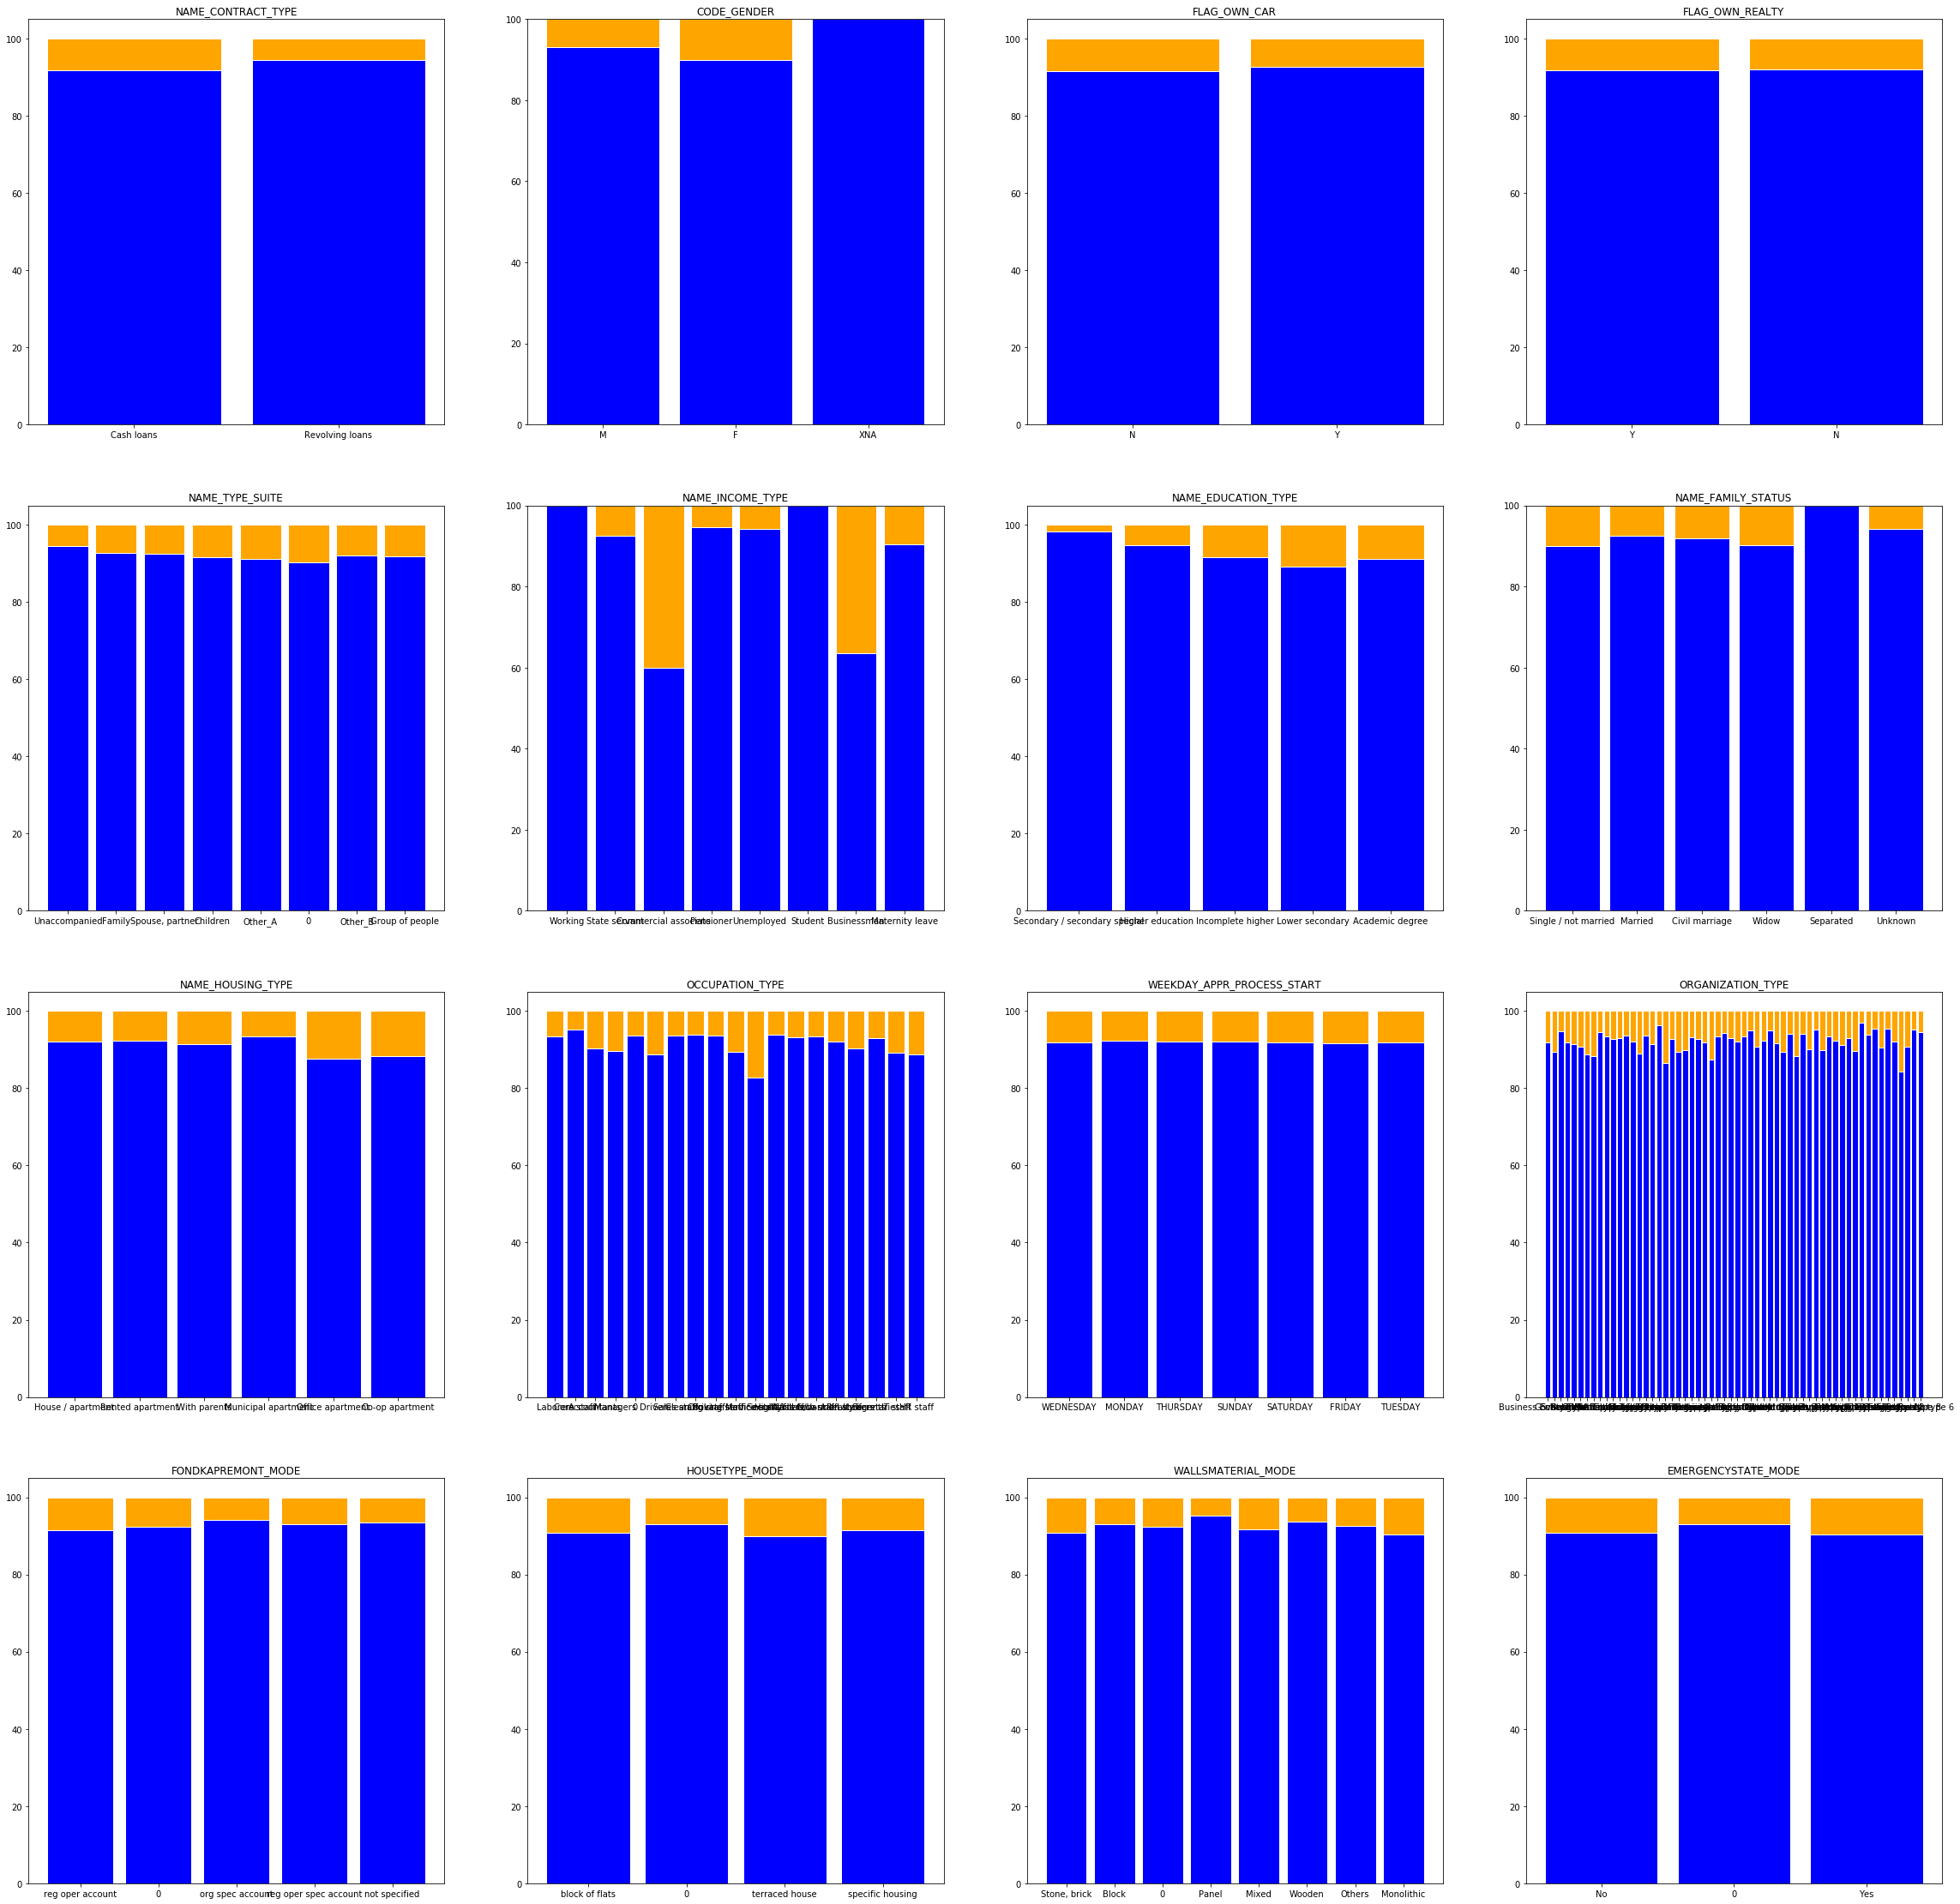

In [13]:
plot_stacked_bars(master,'TARGET','SK_ID_CURR')

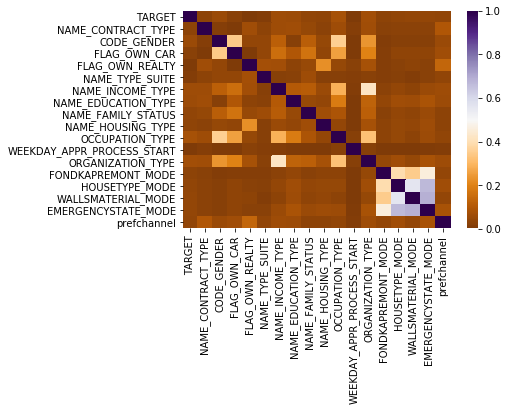

In [18]:
df = master.drop(['SK_ID_CURR'],axis=1).copy()
df['TARGET'] = df['TARGET'].astype('object') 
categcols = list(df.select_dtypes(include = "object").columns)
assoc_table = np.empty((len(categcols),len(categcols)))
i=0
j=0

while i<len(categcols):
    while j<len(categcols):
        v1=df[categcols[i]]
        v2=df[categcols[j]]
        assoc_table[i,j] = cramers_v(v1,v2)
        j=j+1
    i=i+1
    j=0

assoc_data = pd.DataFrame(assoc_table,index=categcols,columns=categcols)
# display(assoc_data)

sb.heatmap(assoc_data, cmap='PuOr')

## Explore Numerical variables

In [19]:
master.drop(['SK_ID_CURR','TARGET'],axis=1).describe()

,Unnamed: 0,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,lastapplamountrequested,avgpastapplamountreq,pastapplamtcredittoreqratio,pastapplcnt_Cashloans,pastapplcnt_Consumerloans,pastapplcnt_Revolvingloans,pastapplcnt_XNA,propconsumerloanswith0downpaym,cntpastapplRefused,cntXsellcreditaccounts
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,...,3.075110e+05,3.075110e+05,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,153755.000000,0.417052,1.687979e+05,5.990260e+05,27107.516051,5.379095e+05,0.020868,-16036.995067,63815.045904,-4986.120328,...,1.578430e+05,1.457651e+05,inf,2.038184,2.033280,0.524755,0.001018,0.379538,0.797988,1.253269
std,88770.923652,0.722121,2.371231e+05,4.024908e+05,14494.443757,3.696338e+05,0.013831,4363.988632,141275.766519,3522.886321,...,2.804727e+05,1.531047e+05,NaN,3.180878,1.828083,0.989541,0.034999,0.409012,1.774843,1.958884
min,0.000000,0.000000,2.565000e+04,4.500000e+04,0.000000,0.000000e+00,0.000290,-25229.000000,-17912.000000,-24672.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,76877.500000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,...,0.000000e+00,5.525100e+04,9.827807e-01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,153755.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,...,6.070950e+04,9.984857e+04,1.045594e+00,1.000000,2.000000,0.000000,0.000000,0.285714,0.000000,0.000000
75%,230632.500000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,-2010.000000,...,1.584000e+05,1.832186e+05,1.122567e+00,3.000000,3.000000,1.000000,0.000000,0.750000,1.000000,2.000000
max,307510.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,...,4.050000e+06,4.050000e+06,inf,60.000000,45.000000,31.000000,3.000000,1.000000,68.000000,51.000000


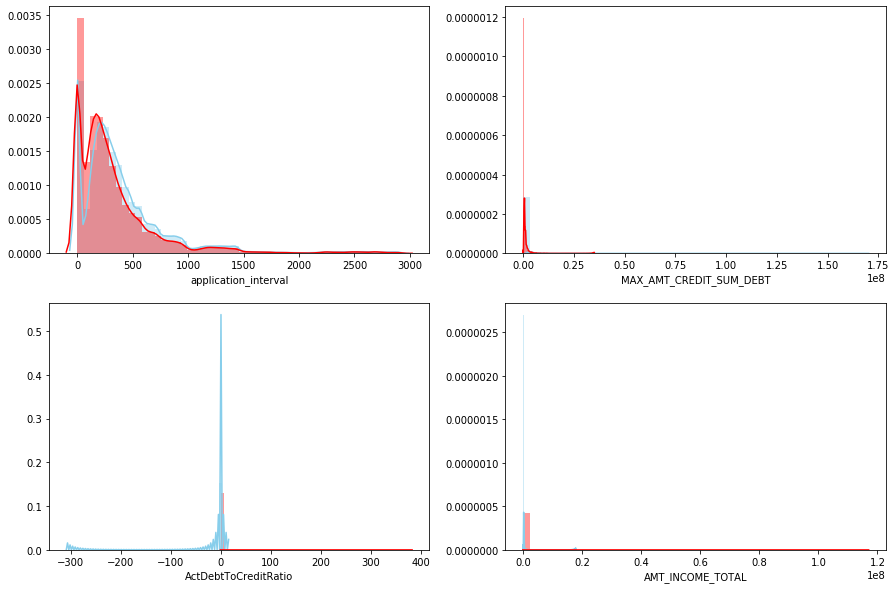

In [170]:
df0 = master[master['TARGET']==0]
df1 = master[master['TARGET']==1]


# numericcolnames = ['application_interval','DAYS_CREDIT_UPDATE','ip_total_less_times_1y','ip_total_actual_payment_1m','MAX_AMT_CREDIT_SUM_DEBT','propdelayedinstalpayments_12months','ActDebtToCreditRatio','AMT_INCOME_TOTAL']


fig, axes = plt.subplots(2, 2, figsize=(15,10))

sb.distplot(df0['application_interval'],color="skyblue",label=var,ax=axes[0,0]);
sb.distplot(df1['application_interval'],color="red",label=var,ax=axes[0,0]);

sb.distplot(df0['MAX_AMT_CREDIT_SUM_DEBT'],color="skyblue",label=var,ax=axes[0,1]);
sb.distplot(df1['MAX_AMT_CREDIT_SUM_DEBT'],color="red",label=var,ax=axes[0,1]);

sb.distplot(df0['ActDebtToCreditRatio'],color="skyblue",label=var,ax=axes[1,0]);
sb.distplot(df1['ActDebtToCreditRatio'],color="red",label=var,ax=axes[1,0]);

sb.distplot(df0['AMT_INCOME_TOTAL'],color="skyblue",label=var,ax=axes[1,1]);
sb.distplot(df1['AMT_INCOME_TOTAL'],color="red",label=var,ax=axes[1,1]);

We will continue exploring numerical variables further once we have reduced our feature set

# Data Modeling

The current dataset is too big for building complex models as my system does not have a GPU. Hence, for the purpose of this project, I will take a random sample of 100,000 rows from the master dataset. This will ensure that the class proportions in the response variable remain approximately the same

In [20]:
model_data = master.sample(n=100000,random_state=710)

In [21]:
model_data['TARGET'].value_counts()

0    92017
1     7983
Name: TARGET, dtype: int64

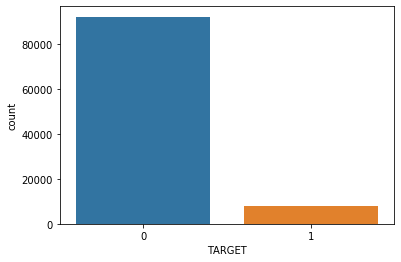

In [62]:
sb.countplot(x='TARGET',data=model_data);

## Convert categorical variables to dummies (Binary encoding)

In [22]:
categ_cols = list(model_data.select_dtypes(include="object").columns)

model_data_v2 = model_data.copy()
for col in categ_cols:
    model_data_v2 = pd.concat([model_data_v2,pd.get_dummies(model_data[col]).add_prefix(col+'_').iloc[:,:-1]],axis=1).drop([col],axis=1)

In [24]:
model_data_v2.shape

(100000, 323)

## Split data into Train and Test samples

In [23]:
from sklearn.model_selection import train_test_split
X = np.array(model_data_v2.drop(['TARGET','SK_ID_CURR'],axis=1))
Y = np.array(model_data_v2[['TARGET']])

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.25,random_state = 710)
x_train_df = pd.DataFrame(x_train, columns = model_data_v2.drop(['TARGET','SK_ID_CURR'],axis=1).columns)

## Data Resampling - Train sample

As the response classes are highly imbalanced in the dataset, we will try resampling the data using the Imbalanced-learn library (https://imbalanced-learn.readthedocs.io/en/stable/install.html) tomek links pairs (https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.TomekLinks.html) and SMOTE

In [30]:
# !pip install imblearn

  Using cached https://files.pythonhosted.org/packages/81/a7/4179e6ebfd654bd0eac0b9c06125b8b4c96a9d0a8ff9e9507eb2a26d2d7e/imblearn-0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c8/73/36a13185c2acff44d601dc6107b5347e075561a49e15ddd4e69988414c3e/imbalanced_learn-0.6.2-py3-none-any.whl


In [34]:
import imblearn
from imblearn.combine import SMOTETomek

smt = SMOTETomek()
x_train_smt, y_train_smt = smt.fit_sample(x_train, y_train)

In [ ]:
# Optional - Generate training samples using only tomek links without smote (Used for 2nd logistic model)

import imblearn
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
x_train_tl, y_train_tl = tl.fit_sample(x_train, y_train)

In [35]:
print(y_train.shape)
print(np.sum(y_train))

print(y_train_smt.shape)
print(np.sum(y_train_smt))

(75000, 1)
5957
(137696,)
68848


## Feature engineering Part II: Feature Selection

### Selection using logistic regression with L1 regularization

In [37]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

x_train_norm = MinMaxScaler().fit_transform(x_train_smt)

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1",solver='liblinear'), '1.25*median')
embeded_lr_selector.fit(x_train_norm, y_train_smt)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = x_train_df.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

139 selected features


In [38]:
print(embeded_lr_feature)

['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_CONT_MOBILE', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LANDAREA_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_10', '

### Selection using RandomForest Classifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='1.25*median')
embeded_rf_selector.fit(x_train_smt, y_train_smt)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = x_train_df.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

153 selected features


In [42]:
# Take features that are common in selection procedures

intersection = set(embeded_lr_feature).intersection(embeded_rf_feature)
selected_features_list = list(intersection)
print(len(selected_features_list))
print(selected_features_list)

77
['application_interval', 'avgdaysinstalpaidinadvance_9months', 'ip_total_actual_payment_1m', 'DAYS_CREDIT_UPDATE', 'ip_total_required_payment_1y', 'ip_total_required_payment_6m', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'EXT_SOURCE_2', 'ip_total_less_times_1y', 'OBS_60_CNT_SOCIAL_CIRCLE', 'ip_payment_count_1y', 'Active', 'ip_total_actual_payment_6m', 'MAX_AMT_CREDIT_SUM_DEBT', 'ip_total_late_times_6m', 'EXT_SOURCE_1', 'propdelayedinstalpayments_12months', 'FLAG_OWN_CAR_N', 'ENTRANCES_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'ACT_AMT_CREDIT_SUM_LIMIT', 'FLOORSMAX_MEDI', 'cntXsellcreditaccounts', 'Credit card_actcredlines', 'CODE_GENDER_F', 'DEF_60_CNT_SOCIAL_CIRCLE', 'avgdaysinstalpaidinadvance_1months', 'LIVINGAREA_MODE', 'pastapplcnt_Cashloans', 'DaysRecentBurCredApplied', 'FLOORSMIN_MEDI', 'ADJ_AMT_CREDIT_MAX_OVERDUE_x', 'AMT_ANNUITY', 'DEF_30_CNT_SOCIAL_CIRCLE', 'ip_payment_count_3m', 'LIVINGAREA_AVG', 'ip_payment_count_1m', 'FLAG_DOCUMENT_3', 'OWN_CAR_AGE', 'NAME_EDUCATION_TYPE_Higher ed

In [46]:
# obtain feature indexes for the selected common features

selected_vars_index =embeded_lr_support & embeded_rf_support
x_train_selected = x_train_smt[:,selected_vars_index]
x_test_selected = x_test[:,selected_vars_index]

In [48]:
x_train_selected.shape

(137696, 77)

After taking the common set of features selected by Regularized logistic regression and Random Forest model, we have a list of 77 predictors

## Logistic regression (with smote - artificial balancing)

### Fit model

In [50]:
from sklearn.linear_model import LogisticRegression

logisticmodel = LogisticRegression(penalty="l2",max_iter=100000)
logisticmodel.fit(x_train_selected, np.ravel(y_train_smt))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Evaluate Model Performance on Train and select optimum probability cutoff

optimum probability is:  [0.35]


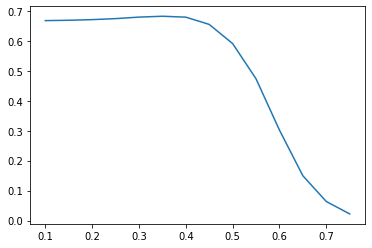

In [82]:
# Choose optimum probability cutoff using F1 score

from sklearn import metrics

train_predprob = logisticmodel.predict_proba(x_train_selected)[:,1].reshape((y_train_smt.shape[0],1))
y_observed = y_train_smt.reshape((y_train_smt.shape[0],1))

prob_array = np.around(np.arange(0.1,0.8,0.05), decimals=2)
F1score_array = np.zeros(prob_array.size)
i=0
for p in prob_array:
    y_predicted = (train_predprob>=p)*1
    F1score_array[i] = metrics.f1_score(y_observed,y_predicted)
    i=i+1

plt.plot(prob_array,F1score_array);

print('optimum probability is: ',prob_array[F1score_array == np.max(F1score_array)])


optimum probability is:  [0.2]


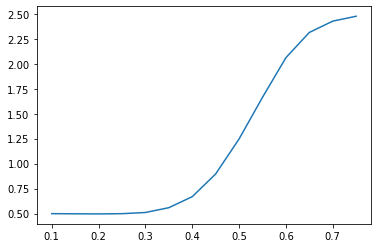

In [83]:
# # Choose optimum probability cutoff using Asymmetric misclassification cost

# from sklearn import metrics

# train_predprob = logisticmodel.predict_proba(x_train_selected)[:,1].reshape((y_train_smt.shape[0],1))
# y_observed = y_train_smt.reshape((y_train_smt.shape[0],1))

# prob_array = np.around(np.arange(0.1,0.8,0.05), decimals=2)
# asym_misclassif_array = np.zeros(prob_array.size)
# i=0
# for p in prob_array:
#     asym_misclassif_array[i] = asymm_misclassif(train_predprob,y_observed,p)
#     i=i+1

# plt.plot(prob_array,asym_misclassif_array) ;
# print('optimum probability is: ',prob_array[asym_misclassif_array == np.min(asym_misclassif_array)])


### Check performance on Test sample

In [85]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

test_predprob = logisticmodel.predict_proba(x_test_selected)[:,1].reshape((y_test.shape[0],1))
y_test_predicted = (test_predprob>0.35)*1
y_test_observed = y_test.reshape((y_test.shape[0],1))

print('Confusion Matrix :')
print(confusion_matrix(y_test_observed,y_test_predicted)) 
print('Accuracy Score :',accuracy_score(y_test_observed, y_test_predicted))
print('Report : ')
print(classification_report(y_test_observed, y_test_predicted))


Confusion Matrix :
[[ 4234 18740]
 [  181  1845]]
Accuracy Score : 0.24316
Report : 
              precision    recall  f1-score   support

           0       0.96      0.18      0.31     22974
           1       0.09      0.91      0.16      2026

    accuracy                           0.24     25000
   macro avg       0.52      0.55      0.24     25000
weighted avg       0.89      0.24      0.30     25000



## Logistic regression (Imbalanced data - Cost sensitive learning)

In this section, we will use the original imbalanced training set, and instead choose the optimum probability by using imbalanced cost of False negative classification. The training set used in this section is obtained after removing tomek link pairs i.e. removes only majority classes that are very closely placed to a minority class

### Fit model

In [88]:
x_train_selected = x_train_tl[:,selected_vars_index]
x_train_selected.shape

(72820, 77)

In [89]:
np.sum(y_train_tl)

5957

In [90]:
from sklearn.linear_model import LogisticRegression

logisticmodel = LogisticRegression(penalty="l2",max_iter=100000)
logisticmodel.fit(x_train_selected, np.ravel(y_train_tl))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Evaluate model performance and choose p_cutoff using asymmetric misclassification cost

optimum probability is:  [0.08]


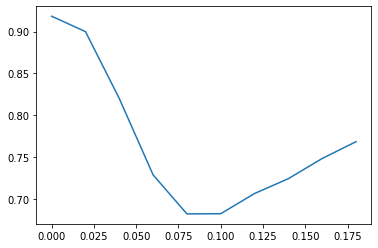

In [113]:
# Choose optimum probability cutoff using Asymmetric misclassification cost

train_predprob = logisticmodel.predict_proba(x_train_selected)[:,1].reshape((y_train_tl.shape[0],1))
y_observed = y_train_tl.reshape((y_train_tl.shape[0],1))

prob_array = np.around(np.arange(0,0.2,0.02), decimals=2)
asym_misclassif_array = np.zeros(prob_array.size)
i=0
for p in prob_array:
    asym_misclassif_array[i] = asymm_misclassif(train_predprob,y_observed,p)
    i=i+1

plt.plot(prob_array,asym_misclassif_array) ;
print('optimum probability is: ',prob_array[asym_misclassif_array == np.min(asym_misclassif_array)])

### Check performance of test sample

In [114]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

test_predprob = logisticmodel.predict_proba(x_test_selected)[:,1].reshape((y_test.shape[0],1))
y_test_predicted = (test_predprob>0.08)*1
y_test_observed = y_test.reshape((y_test.shape[0],1))

print('Confusion Matrix :')
print(confusion_matrix(y_test_observed,y_test_predicted))
print('Accuracy Score :',accuracy_score(y_test_observed, y_test_predicted))
print('Report : ')
print(classification_report(y_test_observed, y_test_predicted))

Confusion Matrix :
[[13376  9598]
 [  762  1264]]
Accuracy Score : 0.5856
Report : 
              precision    recall  f1-score   support

           0       0.95      0.58      0.72     22974
           1       0.12      0.62      0.20      2026

    accuracy                           0.59     25000
   macro avg       0.53      0.60      0.46     25000
weighted avg       0.88      0.59      0.68     25000



## XGboost

In [117]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [119]:
import xgboost  as xgb

### Fit model

In [121]:
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=1000, learning_rate=0.05)
gbm.fit(x_train_selected,y_train_tl)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

### Choose optimum cutoff probability

optimum probability is:  [0.11]


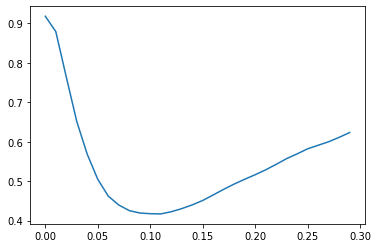

In [122]:
train_predprob = gbm.predict_proba(x_train_selected)[:,1].reshape((y_train_tl.shape[0],1))
y_observed = y_train_tl.reshape((y_train_tl.shape[0],1))

prob_array = np.around(np.arange(0,0.3,0.01), decimals=2)
asym_misclassif_array = np.zeros(prob_array.size)
i=0
for p in prob_array:
    asym_misclassif_array[i] = asymm_misclassif(train_predprob,y_observed,p)
    i=i+1

plt.plot(prob_array,asym_misclassif_array) ;
print('optimum probability is: ',prob_array[asym_misclassif_array == np.min(asym_misclassif_array)])

### Predict on test set and report performance

In [123]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

test_predprob = gbm.predict_proba(x_test_selected)[:,1].reshape((y_test.shape[0],1))
y_test_predicted = (test_predprob>0.11)*1
y_test_observed = y_test.reshape((y_test.shape[0],1))

print('Confusion Matrix :')
print(confusion_matrix(y_test_observed,y_test_predicted))
print('Accuracy Score :',accuracy_score(y_test_observed, y_test_predicted))
print('Report : ')
print(classification_report(y_test_observed, y_test_predicted))

Confusion Matrix :
[[18605  4369]
 [  869  1157]]
Accuracy Score : 0.79048
Report : 
              precision    recall  f1-score   support

           0       0.96      0.81      0.88     22974
           1       0.21      0.57      0.31      2026

    accuracy                           0.79     25000
   macro avg       0.58      0.69      0.59     25000
weighted avg       0.89      0.79      0.83     25000



## Artificial Neural Network

In [128]:
import keras

Using TensorFlow backend.


In [129]:
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

### Design layer architecture

In [150]:
# For the scope of this project, we will use a 6-layer deep network (5 hidden layers) and gradually reduce the number of units in each layer


model = Sequential()
model.add(Dense(50, input_shape=(x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(30))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(5))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

# Use Adam optimizer

my_optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-08)
model.compile(optimizer=my_optimizer, loss='binary_crossentropy')
early_stopping_monitor = EarlyStopping(patience=6)

In [142]:
Adam?

### Fit model on training set

In [ ]:
# Due to memory limitations, I have not tuned model parameters and am using default values for some parameters

In [147]:
x_train_norm = MinMaxScaler().fit_transform(x_train)

In [158]:
model.fit(x_train_norm, y_train, batch_size=100,epochs=50, callbacks=[early_stopping_monitor],class_weight={0:1,1:10})

Epoch 1/50
75000/75000 [==============================] - 2s 25us/step - loss: 1.0069
Epoch 2/50
 5800/75000 [=>............................] - ETA: 1s - loss: 0.9662

C:\Users\Hi\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



75000/75000 [==============================] - 2s 25us/step - loss: 0.9858
Epoch 3/50
75000/75000 [==============================] - 2s 28us/step - loss: 0.9779
Epoch 4/50
75000/75000 [==============================] - 2s 25us/step - loss: 0.9693
Epoch 5/50
75000/75000 [==============================] - 2s 25us/step - loss: 0.9609
Epoch 6/50
75000/75000 [==============================] - 2s 25us/step - loss: 0.9526
Epoch 7/50
75000/75000 [==============================] - 2s 25us/step - loss: 0.9418
Epoch 8/50
75000/75000 [==============================] - 2s 25us/step - loss: 0.9330
Epoch 9/50
75000/75000 [==============================] - 2s 26us/step - loss: 0.9226
Epoch 10/50
75000/75000 [==============================] - 2s 25us/step - loss: 0.9132
Epoch 11/50
75000/75000 [==============================] - 2s 25us/step - loss: 0.9036
Epoch 12/50
75000/75000 [==============================] - 2s 25us/step - loss: 0.8914
Epoch 13/50
75000/75000 [==============================] - 2s 

In [153]:
model.predict_proba?

### Choose optimum p-cutoff

Since class weights were added during training, p-cutoff is chosen using symmetric misclassification

optimum probability is:  [0.29]


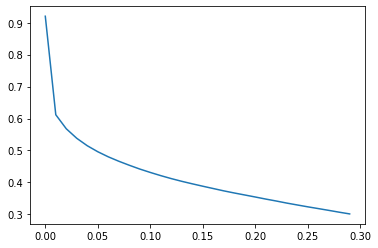

In [159]:
train_predprob = model.predict_proba(x_train_norm)[:,0].reshape((y_train.shape[0],1))
y_observed = y_train.reshape((y_train.shape[0],1))

prob_array = np.around(np.arange(0,0.3,0.01), decimals=2)
sym_misclassif_array = np.zeros(prob_array.size)
i=0
for p in prob_array:
    sym_misclassif_array[i] = symm_misclassif(train_predprob,y_observed,p)
    i=i+1

plt.plot(prob_array,sym_misclassif_array) ;
print('optimum probability is: ',prob_array[sym_misclassif_array == np.min(sym_misclassif_array)])

### Predict on Test and report performance

In [160]:
test_predprob = model.predict_proba(x_test)[:,0].reshape((y_test.shape[0],1))
y_test_predicted = (test_predprob>0.29)*1
y_test_observed = y_test.reshape((y_test.shape[0],1))

print('Confusion Matrix :')
print(confusion_matrix(y_test_observed,y_test_predicted))
print('Accuracy Score :',accuracy_score(y_test_observed, y_test_predicted))
print('Report : ')
print(classification_report(y_test_observed, y_test_predicted))

Confusion Matrix :
[[16142  6832]
 [ 1283   743]]
Accuracy Score : 0.6754
Report : 
              precision    recall  f1-score   support

           0       0.93      0.70      0.80     22974
           1       0.10      0.37      0.15      2026

    accuracy                           0.68     25000
   macro avg       0.51      0.53      0.48     25000
weighted avg       0.86      0.68      0.75     25000

